# Overwriting feature layers

As content publishers, you may be required to keep certain web layers up to date. As new data arrives, you may have to append new features, update existing features etc. There are a couple of different options to accomplish this:
 
 - Method 1: editing individual features as updated datasets are available
 - Method 2: overwriting feature layers altogether with updated datasets
 
Depending on the number of features that are updated, your workflow requirements, you may adopt either or both kinds of update mechanisms.

In the sample [Updating features in a feature layer](python/sample-notebooks/updating-features-in-a-feature-layer/) we explore method 1. In this sample, we explore method 2.

**Method 2**
 - [Introduction](#Introduction)
 - [Publish the cities feature layer using the initial dataset](Publish-the-cities-feature-layer-using-the-initial-dataset)
 - [Merge updates from spreadsheets 1 and 2](#Merge-updates-from-spreadsheets-1-and-2)
   - [Write the updates to disk](#Write-the-updates-to-disk)
 - [Overwrite the feature layer](#Overwrite-the-feature-layer)
   - [Access the overwritten feature layer](#Access-the-overwritten-feature-layer)
 - [Conclusion](#Conclusion)

In [1]:
# Import libraries
from arcgis.gis import GIS
from arcgis import features
from getpass import getpass #to accept passwords in an interactive fashion
import pandas as pd

In [26]:
# Connect to the GIS
password = getpass()
gis = GIS("https://www.arcgis.com/",'arcgis_python', password)

········


## Publish the cities feature layer using the initial dataset

In [27]:
# read the initial csv
csv1 = 'capitals_A1.csv'
cities_df_1 = pd.read_csv(csv1)
cities_df_1.head()

,city_id,name,state,capital,pop2000,pop2007,longitude,latitude
0,1,Honolulu,HI,State,371657,378587,-157.823436,21.305782
1,2,Juneau,AK,State,30711,31592,-134.511582,58.351418
2,3,Boise City,ID,State,185787,203529,-116.237655,43.613736
3,4,Olympia,WA,State,27514,45523,-122.893073,47.042418
4,5,Salem,OR,State,136924,152039,-123.029155,44.931109


In [28]:
# print the number of records in this csv
cities_df_1.shape

(19, 8)

In [29]:
# add the csv as an item
item_prop = {'title':'USA Capitals spreadsheet UC'}
csv_item = gis.content.add(item_properties=item_prop, data=csv1)
csv_item

<Item title:"USA Capitals spreadsheet UC" type:CSV owner:arcgis_python>

In [30]:
# publish the csv item into a feature layer
cities_item = csv_item.publish()
cities_item

<Item title:"USA Capitals spreadsheet UC" type:Feature Layer Collection owner:arcgis_python>

<Item title:"USA Capitals 2" type:Feature Layer Collection owner:arcgis_python>
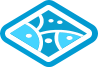

In [31]:
# update the item metadata
item_prop = {'title':'USA Capitals 2'}
cities_item.update(item_properties = item_prop, 
                   thumbnail='capital_cities.png')
cities_item

In [35]:
map1 = gis.map('USA')
map1

In [36]:
map1.add_layer(cities_item)

In [32]:
cities_item.url

'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/USA_Capitals_spreadsheet_UC/FeatureServer'

## Merge updates from spreadsheet 2 with 1
The next set of updates have arrived and are stored in `usa_capitals_2.csv`. We are told it contains corrections for the original set of features and also has new features.

Instead of applying the updates one at a time, we will merge both the spreadsheets into a new one.

In [18]:
# read the second csv set
csv2 = 'capitals_A2.csv'
cities_df_2 = pd.read_csv(csv2)
cities_df_2.head(5)

,city_id,name,state,capital,pop2000,pop2007,longitude,latitude
0,20,Baton Rouge,LA,State,227818,228810,-91.140227,30.458091
1,21,Helena,MT,State,25780,26007,-112.027027,46.595809
2,22,Bismarck,ND,State,55532,59344,-100.779000,46.813346
3,23,Pierre,SD,State,13876,14169,-100.336382,44.367964
4,24,St. Paul,MN,State,287151,291643,-93.114118,44.954364


In [19]:
# get the dimensions of this csv
cities_df_2.shape

(36, 8)

Let us `append` the spreadsheets 1 and 2 and store it in a DataFrame called `updated_df`. Note, this step introduces duplicate rows that were updated in spreadsheet 2.

In [20]:
updated_df = cities_df_1.append(cities_df_2)
updated_df.shape

(55, 8)

Next, we must drop the duplicate rows. Note, in this sample, the `city_id` column has unique values and is present in all spreadsheets. Thus, we are able to determine duplicate rows using this column and drop them.

In [21]:
updated_df.drop_duplicates(subset='city_id', keep='last', inplace=True)
# we specify argument keep = 'last' to retain edits from second spreadsheet
updated_df.shape

(51, 8)

Thus we have dropped 4 rows from spreadsheet 1 and retained the same 4 rows with updated values from spreadsheet 2. Let us see how the DataFrame looks so far:

In [22]:
updated_df.head(5)

,city_id,name,state,capital,pop2000,pop2007,longitude,latitude
0,1,Honolulu,HI,State,371657,378587,-157.823436,21.305782
1,2,Juneau,AK,State,30711,31592,-134.511582,58.351418
2,3,Boise City,ID,State,185787,203529,-116.237655,43.613736
4,5,Salem,OR,State,136924,152039,-123.029155,44.931109
5,6,Carson,NV,State,52457,56641,-119.753873,39.160946


### Write the updates to disk
Let us create a new folder called `updated_capitals_csv` and write the updated features to a csv with the same name as our first csv file.

In [23]:
updated_df.to_csv('updated_capitals_csv/usa_capitals_1.csv')

## Overwrite the feature layer
Let us overwrite the feature layer using the new csv file we just created. To overwrite, we will use the `overwrite()` method.

In [33]:
from arcgis.features import FeatureLayerCollection
cities_flayer_collection = FeatureLayerCollection.fromitem(cities_item)

In [34]:
#call the overwrite() method which can be accessed using the manager property
cities_flayer_collection.manager.overwrite('updated_capitals_csv/usa_capitals_1.csv')

{'success': True}

### Access the overwritten feature layer
Let us query the feature layer and verify the number of features has increased to `51`.

In [37]:
cities_flayer = cities_item.layers[0] #there is only 1 layer
cities_flayer.query(return_count_only=True) #get the total number of features

51

Let us draw this new layer in map

In [22]:
map2 = gis.map("USA")
map2

In [23]:
map2.add_layer(cities_item)

As seen from the map, the number of features has increased while the symbology while the attribute columns remain the same as original.

# Add additional attribute columns to the feature layer

In [39]:
# read the third csv set
csv3 = 'capitals_annex_A.csv'
cities_df_3 = pd.read_csv(csv3)
cities_df_3.head()

,city_id,name,class,white,black,ameri_es,asian,hawn_pl,hispanic,males,females
0,1,Honolulu,Census Designated Place,73093,6038,689,207588,25457,16229,182628,189029
1,2,Juneau,City and Borough,22969,248,3496,1438,116,1040,15469,15242
2,3,Boise City,City,171204,1437,1300,3870,302,8410,92014,93773
3,4,Olympia,City,36246,805,553,2473,125,1863,20319,22195
4,5,Salem,City,113746,1750,2064,3304,643,19973,68752,68172


In [ ]:
#find the number of rows in the third csv
cities_df_3.shape

(51, 11)

The columns `City_ID` and `NAME` are common to all 3 spreadsheets. Next let us take a look at how we can append this additional attribute information to our feature layer.

#### Inspecting existing fields of the feature layer
The `manager` property of the `FeatureLayer` object exposes a set of methods to read and update the properties and definition of feature layers.

In [43]:
#Get the existing list of fields on the cities feature layer
cities_fields = cities_flayer.manager.properties.fields
for field in cities_fields:
    print(field['name'])

city_id
name
state
capital
pop2000
pop2007
longitude
latitude
FID


In [44]:
#take a look at one of the fields
cities_fields[0]

{
  "alias": "city_id",
  "domain": null,
  "name": "city_id",
  "type": "esriFieldTypeInteger",
  "defaultValue": null,
  "actualType": "int",
  "sqlType": "sqlTypeInteger",
  "visible": true,
  "editable": true,
  "nullable": true
}

In [53]:
#Loop through and print all the fields with details
print("{:10s} | {:10s} | {:20s} | {:15s}".format('field.name', 'field.alias', 'field.type', 'field.sqlType'))
for field in cities_fields:
    print("{:10s} | {:10s} | {:20s} | {:15s}".format(field.name, field.alias, field.type, field.sqlType))

field.name | field.alias | field.type           | field.sqlType  
city_id    | city_id    | esriFieldTypeInteger | sqlTypeInteger 
name       | name       | esriFieldTypeString  | sqlTypeNVarchar
state      | state      | esriFieldTypeString  | sqlTypeNVarchar
capital    | capital    | esriFieldTypeString  | sqlTypeNVarchar
pop2000    | pop2000    | esriFieldTypeInteger | sqlTypeInteger 
pop2007    | pop2007    | esriFieldTypeInteger | sqlTypeInteger 
longitude  | longitude  | esriFieldTypeDouble  | sqlTypeFloat   
latitude   | latitude   | esriFieldTypeDouble  | sqlTypeFloat   
FID        | FID        | esriFieldTypeInteger | sqlTypeInteger 


### Copy a field and use that as a template to create new fields

In [57]:
from copy import deepcopy
# get a template field
template_field = dict(deepcopy(cities_fields[0]))
template_field

{'actualType': 'int',
 'alias': 'city_id',
 'defaultValue': None,
 'domain': None,
 'editable': True,
 'name': 'city_id',
 'nullable': True,
 'sqlType': 'sqlTypeInteger',
 'type': 'esriFieldTypeInteger',
 'visible': True}

#### Get existing fields from the feature layer and find the ones that are new

In [61]:
cities_flayer_fset = cities_flayer.query()
cities_flayer_df = cities_flayer_fset.df
cities_flayer_df.head(3)

,FID,capital,city_id,latitude,longitude,name,pop2000,pop2007,state,SHAPE
0,1,State,1,21.305782,-157.823436,Honolulu,371657,378587,HI,"{'x': -17568824.5530287, 'y': 2428377.3527147067}"
1,2,State,2,58.351418,-134.511582,Juneau,30711,31592,AK,"{'x': -14973760.769509867, 'y': 8041504.674188..."
2,3,State,3,43.613736,-116.237655,Boise City,185787,203529,ID,"{'x': -12939516.521076413, 'y': 5405860.248118..."


In [62]:
# get the list of new fields to add from the third spreadsheet, that are not in spread sheets 1,2
new_field_names = list(cities_df_3.columns.difference(cities_flayer_df.columns))
new_field_names

['ameri_es',
 'asian',
 'black',
 'class',
 'females',
 'hawn_pl',
 'hispanic',
 'males',
 'white']

Now loop though each new field name and create a field dictionary using the template we created earlier. Except the field titled `class` all other fields are of type `integer`.

In [63]:
fields_to_be_added = []
for new_field_name in new_field_names:
    current_field = deepcopy(template_field)
    if new_field_name.lower() == 'class':
        current_field['sqlType'] = 'sqlTypeVarchar'
        current_field['type'] = 'esriFieldTypeString'
        current_field['length'] = 8000
        
    current_field['name'] = new_field_name.lower()
    current_field['alias'] = new_field_name
    fields_to_be_added.append(current_field)
    
len(fields_to_be_added)

9

In [64]:
#inspect one of the fields
fields_to_be_added[3]

{'actualType': 'int',
 'alias': 'class',
 'defaultValue': None,
 'domain': None,
 'editable': True,
 'length': 8000,
 'name': 'class',
 'nullable': True,
 'sqlType': 'sqlTypeVarchar',
 'type': 'esriFieldTypeString',
 'visible': True}

#### Adding additional fields to the feature layer
The list of new fields we composed can be pushed to the server by calling `add_to_definition()` method on the `manager` property.

In [65]:
cities_flayer.manager.add_to_definition({'fields':fields_to_be_added})

{'success': True}

Thus, we have successfully added new fields to our feature layer. Let us verify the new columns show up:

In [66]:
new_cities_fields = cities_flayer.manager.properties.fields
len(new_cities_fields)

18

In [68]:
for field in new_cities_fields:
    print('{:10s} | {:10s}'.format(field.name,field.type))

city_id    | esriFieldTypeInteger
name       | esriFieldTypeString
state      | esriFieldTypeString
capital    | esriFieldTypeString
pop2000    | esriFieldTypeInteger
pop2007    | esriFieldTypeInteger
longitude  | esriFieldTypeDouble
latitude   | esriFieldTypeDouble
FID        | esriFieldTypeInteger
ameri_es   | esriFieldTypeInteger
asian      | esriFieldTypeInteger
black      | esriFieldTypeInteger
class      | esriFieldTypeString
females    | esriFieldTypeInteger
hawn_pl    | esriFieldTypeInteger
hispanic   | esriFieldTypeInteger
males      | esriFieldTypeInteger
white      | esriFieldTypeInteger


#### Adding attribute values to the new columns
Next we can loop through each row in the third csv and add the new attribute values for these newly created columns.

In [69]:
# Run a fresh query on the feature layer so it includes the new features from
# csv2 and new columns from csv3
cities_fset2 = cities_flayer.query()
cities_features2 = cities_fset2.features

Loop through each row in the third spreadsheet, find the corresponding feature by matching the `city_id` value and apply the attribute values for the new fields.

In [72]:
import time
features_for_update = []
for city_id in cities_df_3['city_id']:
    # get the matching row from csv
    matching_row = cities_df_3.where(cities_df_3.city_id == city_id).dropna()
    
    print(str(city_id) + " Adding additional attributes for: " + matching_row['name'].values[0])
    
    # get the feature to be updated
    original_feature = [f for f in cities_features2 if f.attributes['city_id'] == city_id][0]
    feature_to_be_updated = deepcopy(original_feature)
    
    # assign the updated values
    feature_to_be_updated.attributes['class'] = matching_row['class'].values[0]
    feature_to_be_updated.attributes['white'] = int(matching_row['white'])
    feature_to_be_updated.attributes['black'] = int(matching_row['black'])
    feature_to_be_updated.attributes['ameri_es'] = int(matching_row['ameri_es'])
    feature_to_be_updated.attributes['asian'] = int(matching_row['asian'])
    feature_to_be_updated.attributes['hawn_pl'] = int(matching_row['hawn_pl'])
    feature_to_be_updated.attributes['hispanic'] = int(matching_row['hispanic'])
    feature_to_be_updated.attributes['males'] = int(matching_row['males'])
    feature_to_be_updated.attributes['females'] = int(matching_row['females'])
    
    #add this to the list of features to be updated
    features_for_update.append(feature_to_be_updated)
    time.sleep(0.25)

1 Adding additional attributes for: Honolulu
2 Adding additional attributes for: Juneau
3 Adding additional attributes for: Boise City
4 Adding additional attributes for: Olympia
5 Adding additional attributes for: Salem
6 Adding additional attributes for: Carson
7 Adding additional attributes for: Sacramento
8 Adding additional attributes for: Phoenix
9 Adding additional attributes for: Salt Lake City
10 Adding additional attributes for: Cheyenne
11 Adding additional attributes for: Denver
12 Adding additional attributes for: Santa Fe
13 Adding additional attributes for: Oklahoma City
14 Adding additional attributes for: Topeka
15 Adding additional attributes for: Lincoln
16 Adding additional attributes for: Des Moines
17 Adding additional attributes for: Jefferson City
18 Adding additional attributes for: Little Rock
19 Adding additional attributes for: Austin
20 Adding additional attributes for: Baton Rouge
21 Adding additional attributes for: Helena
22 Adding additional attributes 

In [73]:
# inspect one of the features
features_for_update[-1]

{"attributes": {"pop2000": 173618, "ameri_es": 1975, "name": "Providence", "latitude": 41.82355466, "hispanic": 52146, "males": 83035, "FID": 47, "state": "RI", "hawn_pl": 270, "pop2007": 183731, "females": 90583, "black": 25243, "asian": 10432, "longitude": -71.42212709, "capital": "State", "class": "City", "city_id": 51, "white": 94666}, "geometry": {"x": -7950674.81903127, "y": 5134585.322608613}}

In [74]:
# apply the edits to the feature layer
cities_flayer.edit_features(updates= features_for_update)

{'addResults': [],
 'deleteResults': [],
 'updateResults': [{'globalId': None, 'objectId': 1, 'success': True},
  {'globalId': None, 'objectId': 2, 'success': True},
  {'globalId': None, 'objectId': 3, 'success': True},
  {'globalId': None, 'objectId': 50, 'success': True},
  {'globalId': None, 'objectId': 4, 'success': True},
  {'globalId': None, 'objectId': 5, 'success': True},
  {'globalId': None, 'objectId': 6, 'success': True},
  {'globalId': None, 'objectId': 7, 'success': True},
  {'globalId': None, 'objectId': 8, 'success': True},
  {'globalId': None, 'objectId': 48, 'success': True},
  {'globalId': None, 'objectId': 9, 'success': True},
  {'globalId': None, 'objectId': 10, 'success': True},
  {'globalId': None, 'objectId': 49, 'success': True},
  {'globalId': None, 'objectId': 11, 'success': True},
  {'globalId': None, 'objectId': 12, 'success': True},
  {'globalId': None, 'objectId': 51, 'success': True},
  {'globalId': None, 'objectId': 13, 'success': True},
  {'globalId': N

#### Verify the changes made so far
Let us run another query on the feature layer and visualize a few rows.

In [75]:
cities_fset3 = cities_flayer.query()
cities_fset3.df.head(5)

,FID,ameri_es,asian,black,capital,city_id,class,females,hawn_pl,hispanic,latitude,longitude,males,name,pop2000,pop2007,state,white,SHAPE
0,1,689,207588,6038,State,1,Census Designated Place,189029,25457,16229,21.305782,-157.823436,182628,Honolulu,371657,378587,HI,73093,"{'x': -17568824.5530287, 'y': 2428377.3527147067}"
1,2,3496,1438,248,State,2,City and Borough,15242,116,1040,58.351418,-134.511582,15469,Juneau,30711,31592,AK,22969,"{'x': -14973760.769509869, 'y': 8041504.674188..."
2,3,1300,3870,1437,State,3,City,93773,302,8410,43.613736,-116.237655,92014,Boise City,185787,203529,ID,171204,"{'x': -12939516.521076413, 'y': 5405860.248118..."
3,4,2064,3304,1750,State,5,City,68172,643,19973,44.931109,-123.029155,68752,Salem,136924,152039,OR,113746,"{'x': -13695542.842798928, 'y': 5610682.54410995}"
4,5,1259,930,946,State,6,City,25355,76,7466,39.160946,-119.753873,27102,Carson,52457,56641,NV,44744,"{'x': -13330940.118354555, 'y': 4744751.946872..."


## Conclusion
Thus, in this sample, we observed how update a feature layer by overwriting it with new content. This method is a lot simpler than method 1 explained in [Updating features in a feature layer](/python/sample-notebooks/updating-features-in-a-feature-layer/) sample. However, with this simplicity, we compromise on our ability to add new columns or change the schema of the feature layer during the update. Further, if your feature layer was updated after it was published, then those updates get overwritten when you perform the overwrite operation. To retain those edits, [extract the data](/python/guide/checking-out-data-from-feature-layers-using-replicas/#Verify-Extract-capability) from the feature layer, merge your updates with this extract, then overwrite the feature layer.